In [1]:
import argparse
import time
import pdb

from anndata import AnnData
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

from data import DatasetWithConfounder
from models import BatchDecoder
from models import HilbertSchmidtAE
from utils import configure_logging
from utils import embed_data, train
from utils import load_data
from utils import set_seeds

from desc_ethan import desc
import scvi
import shutil
from pathlib import Path

from utils import silhouette
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import sem

from utils import ebm, knn_purity
import pickle

configure_logging()
set_seeds(12345)

In [2]:
import matplotlib

adata = load_data("pancreas_generalization", normalized=True)

adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
adata.obs["study"] = adata.obs["study"].astype("category")

pancreas_study_cmap = matplotlib.cm.get_cmap("Dark2")
pancreas_study_cmap = [
    pancreas_study_cmap(0),
    pancreas_study_cmap(6),
    pancreas_study_cmap(4),
    pancreas_study_cmap(7),
    pancreas_study_cmap(5),
]

cell_cmap = matplotlib.cm.get_cmap("tab20")

pancreas_cell_cmap_map = {}
for i, cell_type in enumerate(adata.obs["cell_type"].unique()):
    pancreas_cell_cmap_map[cell_type] = cell_cmap(i)
    
pancreas_study_cmap_map = {}
for i, study in enumerate(adata.obs["study"].unique()):
    pancreas_study_cmap_map[study]= pancreas_study_cmap[i]
    
study_cmaps = {}
cell_type_cmaps = {}

study_cmaps["pancreas_generalization"] = pancreas_study_cmap_map
cell_type_cmaps["pancreas_generalization"] = pancreas_cell_cmap_map

adata = load_data("pbmc_generalization", normalized=True)

cell_cmap = matplotlib.cm.get_cmap("tab10_r")
pbmc_study_cmap = matplotlib.cm.get_cmap("Paired_r")

pbmc_cell_cmap_map = {}
for i, cell_type in enumerate(adata.obs["cell_type"].unique()):
    pbmc_cell_cmap_map[cell_type] = cell_cmap(i)

pbmc_study_cmap_map = {}
for i, study in enumerate(adata.obs["study"].unique()):
    pbmc_study_cmap_map[study]= pbmc_study_cmap(i)
pbmc_study_cmap_map['10x Chromium (v2) B'] = pbmc_study_cmap(11)
pbmc_study_cmap_map['Drop-seq'] = pbmc_study_cmap(10)

study_cmaps["pbmc_generalization"] = pbmc_study_cmap_map
cell_type_cmaps["pbmc_generalization"] = pbmc_cell_cmap_map

In [3]:
methods = ['mnnCorrect', 'seurat', 'harmony', 'conos', 'saucie', 'desc', 'scAlign', 'scvi', 'hd-md', 'hd-md_generalization']
proper_names = ['MNN', 'Seurat', 'Harmony', 'Conos', 'SAUCIE', 'DESC', 'scAlign', 'scVI', 'HD-AE', 'HD-AE*']
deep_methods = ['saucie', 'desc', 'scvi', 'hd-md']

In [4]:
import pickle
ebm_scores = np.load("ebm_scores_50.npy")
purity_scores = np.load("purity_scores_50.npy")
scores = pickle.load(open("scores", "rb"))
errors = np.load("errors.npy")
silhouette_df = pickle.load(open("silhouette_df", "rb"))

In [5]:
### Removing MNN for now.

ebm_scores = ebm_scores[1:,]
purity_scores = purity_scores[1:,]
scores = scores.drop('mnnCorrect', 1)
errors = errors[:,1:]
silhouette_df = silhouette_df[silhouette_df["Method"] != "MNN"]


In [6]:
silhouette_df.loc[silhouette_df["Method"] == "HD-AE", "Method"] = "HD-AE (TL)"
silhouette_df.loc[silhouette_df["Method"] == "HD-AE*", "Method"] = "HD-AE (Full)"
silhouette_df["Method"].unique()

array(['Seurat', 'Harmony', 'Conos', 'SAUCIE', 'DESC', 'scAlign', 'scVI',
       'HD-AE (TL)', 'HD-AE (Full)'], dtype=object)

<ipython-input-10-228410d802fb>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(["" for _ in range(len(methods))])
<ipython-input-10-228410d802fb>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(["" for _ in range(len(methods))])
<ipython-input-10-228410d802fb>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(["" for _ in range(len(methods))])


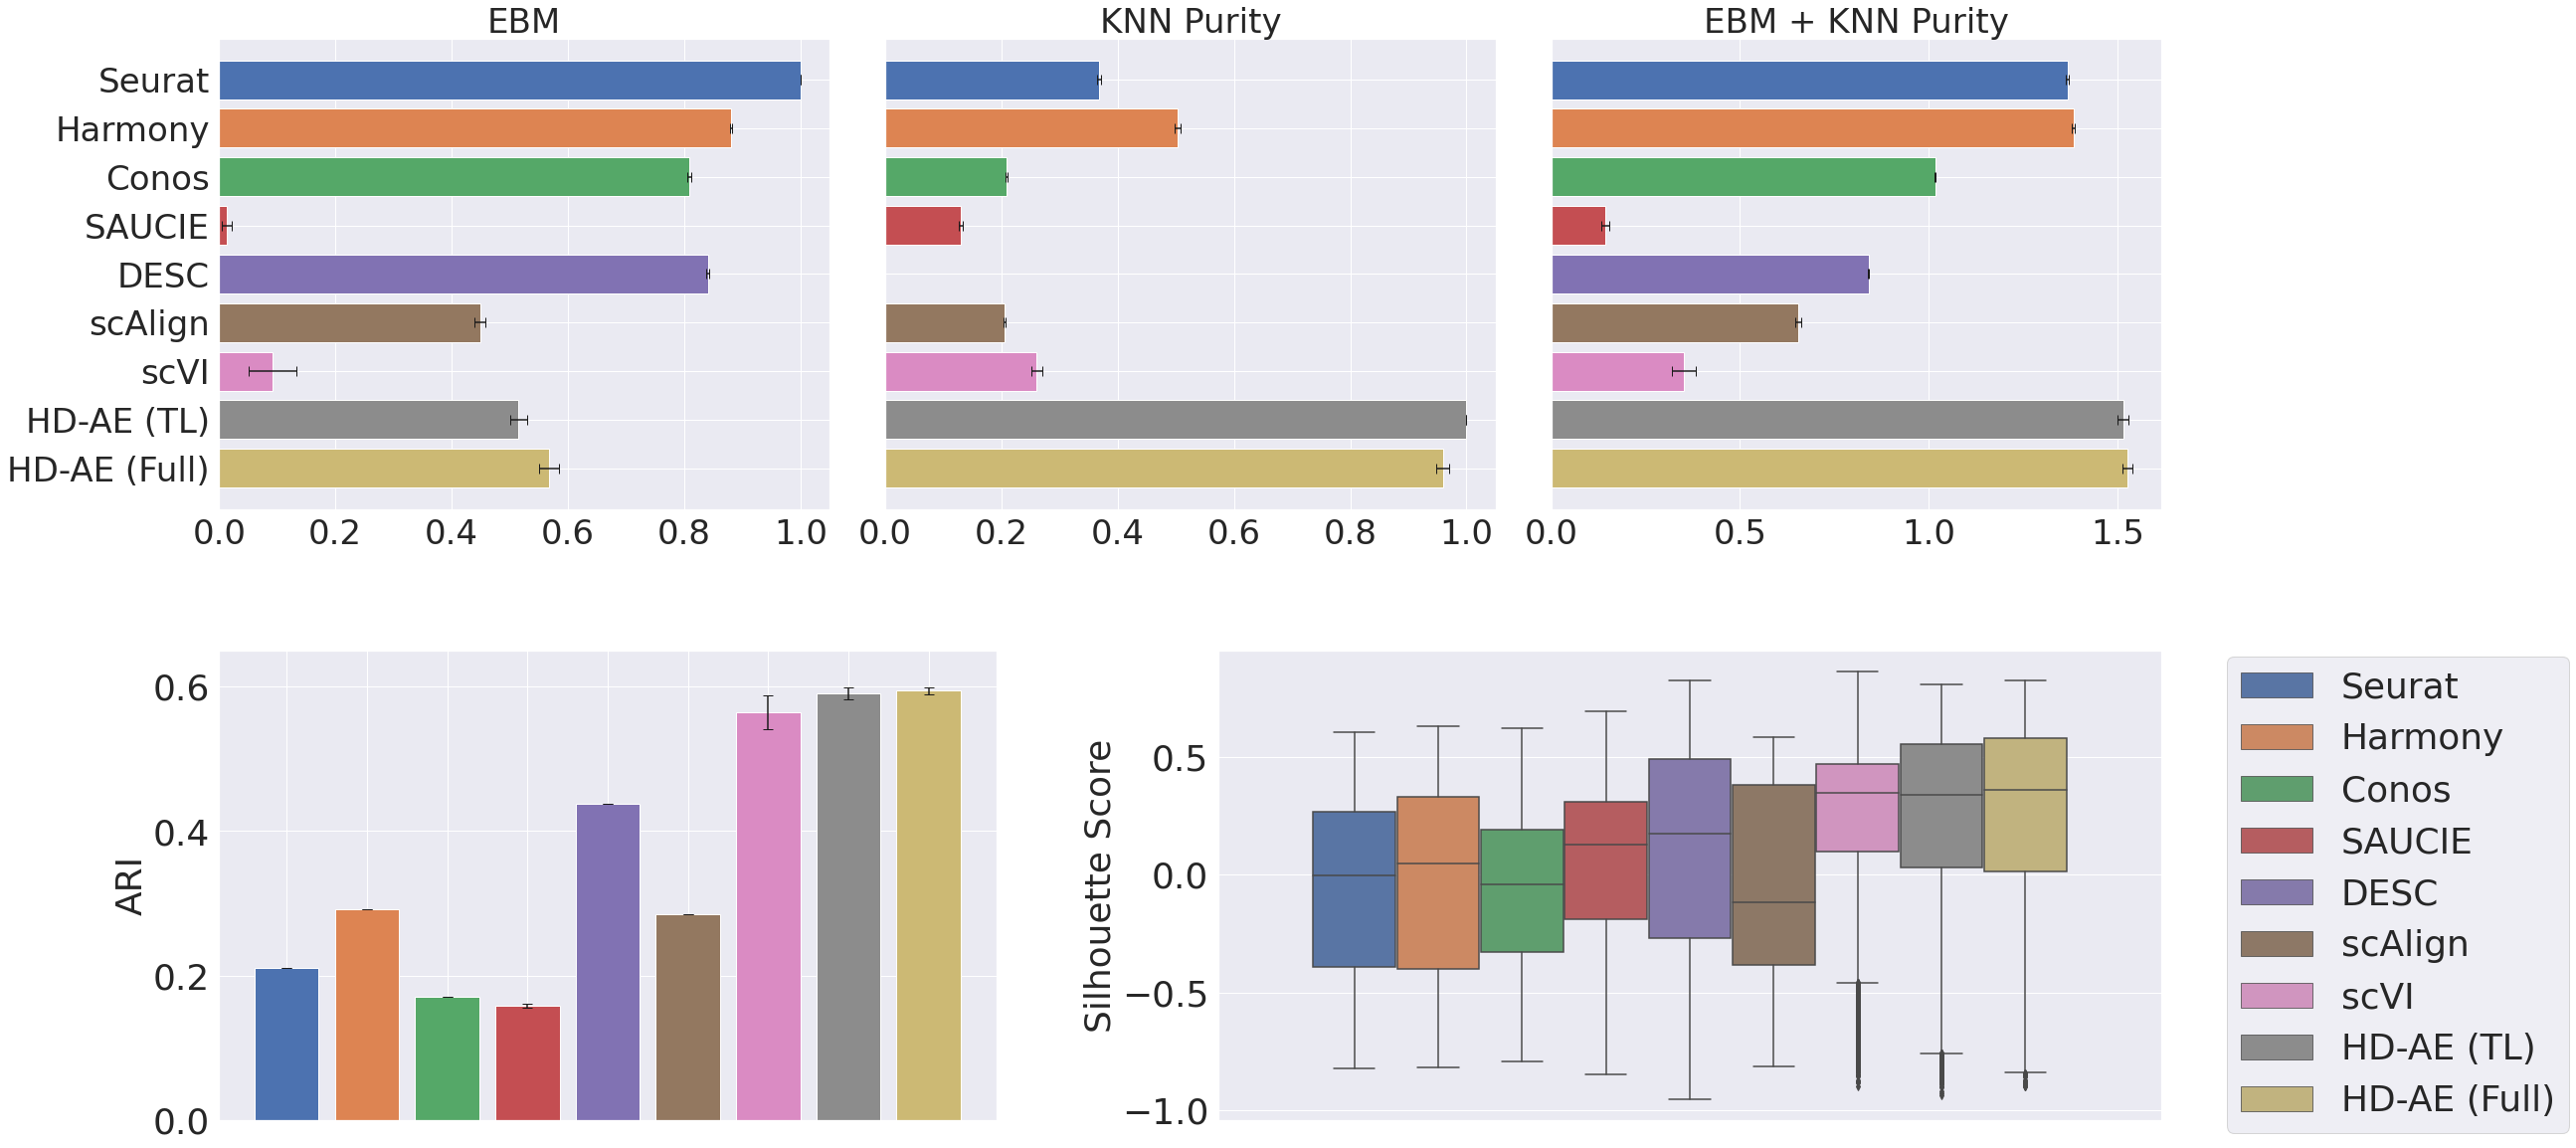

In [10]:
methods = ['seurat', 'harmony', 'conos', 'saucie', 'desc', 'scAlign', 'scvi', 'hd-md', 'hd-md_generalization']
proper_names = ['Seurat', 'Harmony', 'Conos', 'SAUCIE', 'DESC', 'scAlign', 'scVI', 'HD-AE (TL)', 'HD-AE (Full)']
deep_methods = ['saucie', 'desc', 'scvi', 'hd-md']

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
%matplotlib inline
sns.set()

fig = plt.figure(figsize=(35, 20))
ax1 = fig.add_subplot(2, 12, (1, 4))
ax2 = fig.add_subplot(2, 12, (5, 8))
ax3 = fig.add_subplot(2, 12, (9, 12))

ax4 = fig.add_subplot(2, 12, (13, 17)) 
ax5 = fig.add_subplot(2, 12, (19, 24)) 

fontsize=34

ax1.yaxis.set_tick_params(labelsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=fontsize)

ax2.yaxis.set_tick_params(labelsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=fontsize)

ax3.yaxis.set_tick_params(labelsize=fontsize)
ax3.xaxis.set_tick_params(labelsize=fontsize)

# set width of bar
barWidth = 0.2
 
# set height of bar
scaled_ebms = MinMaxScaler().fit_transform(ebm_scores)
scaled_purities = MinMaxScaler().fit_transform(purity_scores)
score_sums = scaled_ebms + scaled_purities

capsize=5
ax1.barh(proper_names, width=scaled_ebms.mean(axis=1), color=list(sns.color_palette()), xerr=sem(scaled_ebms, axis=1), capsize=capsize)
ax1.invert_yaxis()
ax2.barh(proper_names, width=scaled_purities.mean(axis=1), color=list(sns.color_palette()), xerr=sem(scaled_purities, axis=1), capsize=capsize)
ax2.invert_yaxis()


ax3.barh(proper_names, width=score_sums.mean(axis=1), color=list(sns.color_palette()), xerr=sem(score_sums, axis=1), capsize=capsize)
ax3.invert_yaxis()
 
ax2.set_yticklabels(["" for _ in range(len(methods))])
ax3.set_yticklabels(["" for _ in range(len(methods))])

ax1.set_title("EBM", fontsize=fontsize)
ax2.set_title("KNN Purity", fontsize=fontsize)
ax3.set_title("EBM + KNN Purity", fontsize=fontsize)

sns.set()
fontsize=36

errors_list = [errors[i, j] for (i, j) in zip(np.argmax(scores.values, axis=0), range(len(methods)))]
ax4.bar(
    proper_names,
    height=np.max(scores.values, axis=0),
    yerr=errors_list,
    color=list(sns.color_palette()),
    capsize=capsize
)

#ax3.plot(resolutions, scores, linewidth=4, marker='o')
#ax3.set_xlabel("Resolution", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
#ax3.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
#ax3.set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", ""])
ax4.set_xticklabels(["" for _ in range(len(methods))])
ax4.set_ylabel("ARI", fontsize=fontsize)
ax4.set_ylim(0, 0.65)

ax5 = sns.boxplot(
    x="Dataset",
    y="Score",
    hue="Method",
    data=silhouette_df,
)

ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.legend(bbox_to_anchor=(1.05, 1.025), loc='upper left', fontsize=fontsize)
ax5.set_ylabel("Silhouette Score", fontsize=fontsize)
ax5.set_xlabel("")
ax5.set_xticks([])

plt.subplots_adjust(wspace = .5, hspace=0.3)

In [ ]:
def load_results(method, dataset, idx=None):
    if method == 'hd-md' or method == 'hd-md_generalization' or method == 'scvi' or method == 'scvi_generalization' or method == 'desc' or method == 'saucie' or method == 'saucie_generalization':
        if idx is not None:
            results_adata = sc.read("results/{}/{}_{}.h5ad".format(dataset, method, idx))
        else:
            results_adata = sc.read("results/{}/{}.h5ad".format(dataset, method))

    elif method == 'conos':
        source_adata = load_data(dataset, normalized=True)
        f = h5py.File("results/{}/conos.h5".format(dataset), 'r')
        x = np.asarray(f['pseudopca']['pseudopca.df'])
        x = x.view(np.float64).reshape(x.shape + (-1,))

        batch_labels = pd.read_csv("results/{}/batch_labels.csv".format(dataset), index_col=0).x

        results_adata = AnnData(X=x, obs={
            "study": batch_labels.values,
            "cell_type": source_adata.obs["cell_type"].values
        })
    else:
        source_adata = load_data(dataset, normalized=True)
        results = pd.read_csv("results/{}/{}.csv".format(dataset, method))

        results = results.transpose()
        results.columns = results.iloc[0]
        results = results[1:]
        results = results.reset_index(drop=True)

        if method == "mnnCorrect" or "seurat":
            if method == 'seurat':
                results = StandardScaler().fit_transform(results)
            results = PCA(n_components=50).fit_transform(results)

        batch_labels = pd.read_csv("results/{}/batch_labels.csv".format(dataset), index_col=0).x

        results_adata = AnnData(X=results, obs={
            "study": batch_labels.values,
            "cell_type": source_adata.obs["cell_type"].values
        })

    return results_adata

In [23]:
import scanpy as sc

def plot_data(dataset, keys, title=None, frameon=False, legend_loc='right margin', batches_to_exclude = []):
    set_seeds()
    sc.set_figure_params(dpi=200)
    adata = load_data(dataset, normalized=True)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata, random_state=42)

    adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
    adata.obs["study"] = adata.obs["study"].astype("category")
    adata = adata[~adata.obs["study"].isin(batches_to_exclude)]

    study_cmap_map = study_cmaps[dataset]
    cell_cmap_map = cell_type_cmaps[dataset]

    adata.uns["study_colors"] = [study_cmap_map[study] for study in adata.obs["study"].cat.categories]
    adata.uns["cell_type_colors"] = [cell_cmap_map[cell_type] for cell_type in adata.obs["cell_type"].cat.categories]

    for key in keys:
        sc.pl.umap(adata, color=key, frameon=frameon, legend_loc=legend_loc, title=title)
        
def plot_results(method, dataset, keys, frameon=False, title=None, legend_loc='right margin', batches_to_exclude = []):
    set_seeds()
    sc.set_figure_params(dpi=200)
    results_adata = load_results(method, dataset)
    sc.pp.neighbors(results_adata)
    sc.tl.umap(results_adata, random_state=42)

    study_cmap_map = study_cmaps[dataset]
    cell_cmap_map = cell_type_cmaps[dataset]
    
    results_adata.obs["study"] = results_adata.obs["study"].astype("category")
    results_adata.obs["cell_type"] = results_adata.obs["cell_type"].astype("category")
    results_adata = results_adata[~results_adata.obs["study"].isin(batches_to_exclude)]
    
    results_adata.uns["study_colors"] = [study_cmap_map[study] for study in results_adata.obs["study"].cat.categories]
    results_adata.uns["cell_type_colors"] = [cell_cmap_map[cell_type] for cell_type in
                                             results_adata.obs["cell_type"].cat.categories]

    #pdb.set_trace()
    for key in keys:
        sc.pl.umap(
            results_adata,
            color=key,
            frameon=frameon,
            legend_loc=legend_loc,
            title=title
        )

         Falling back to preprocessing with `sc.pp.pca` and default params.


/homes/gws/ewein/miniconda3/envs/batch_effects/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


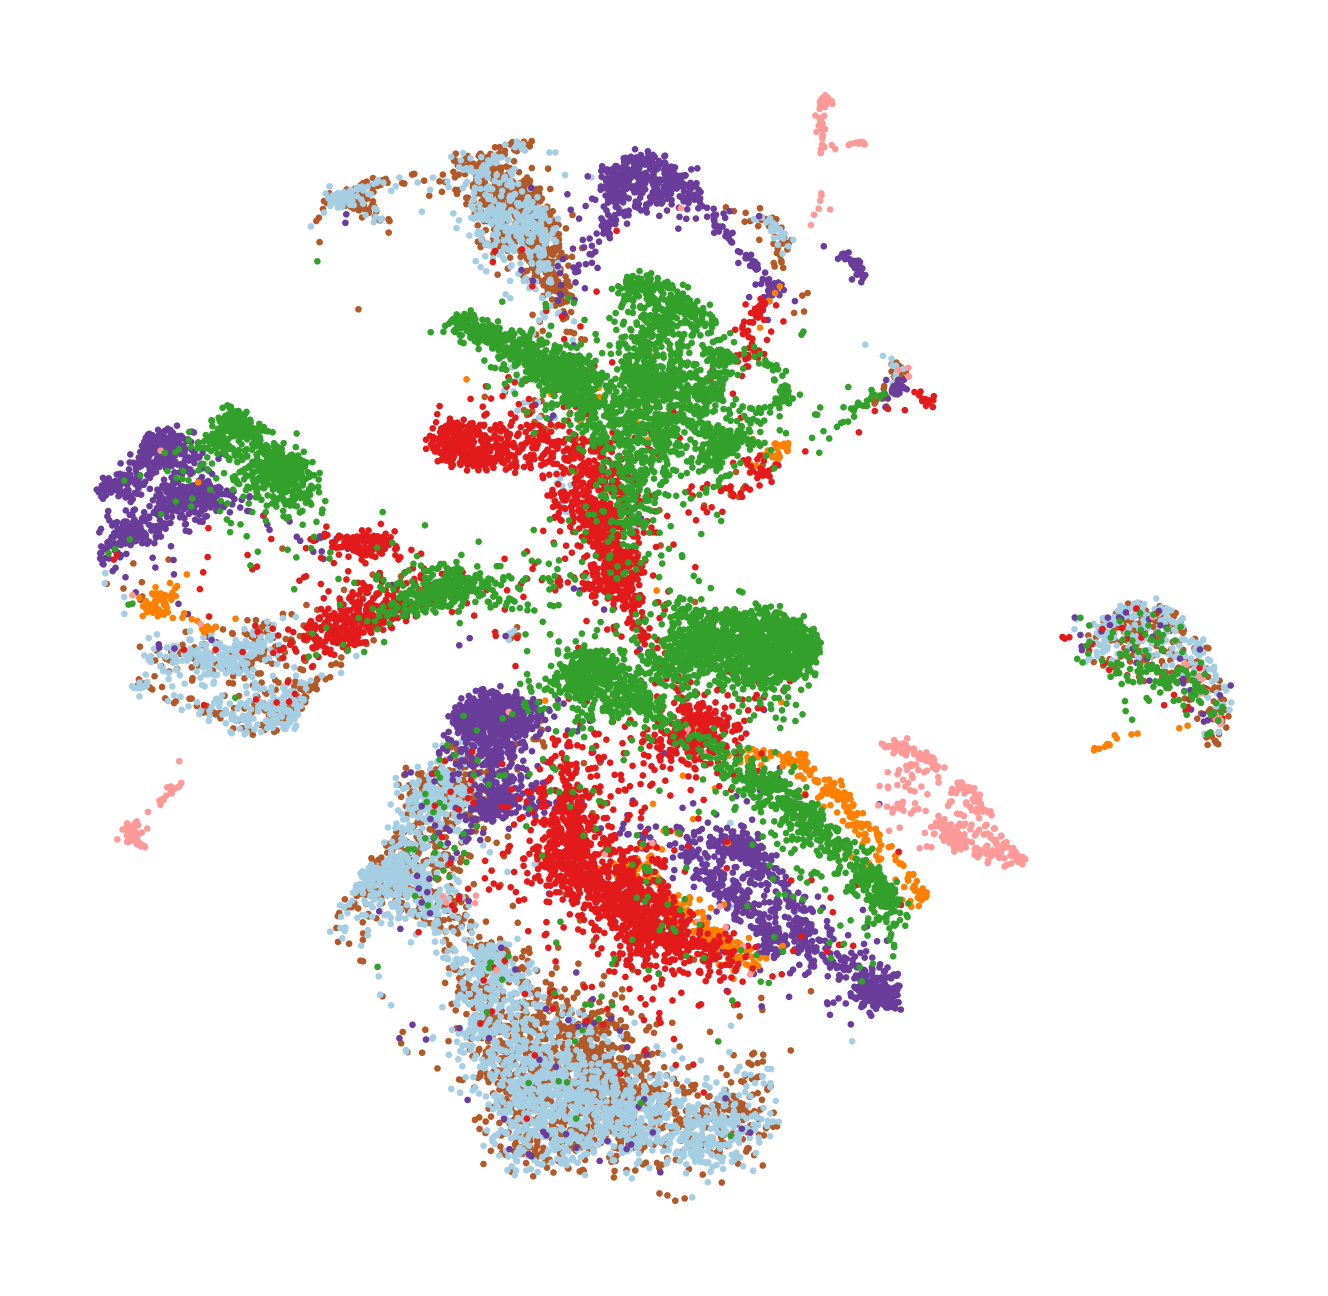

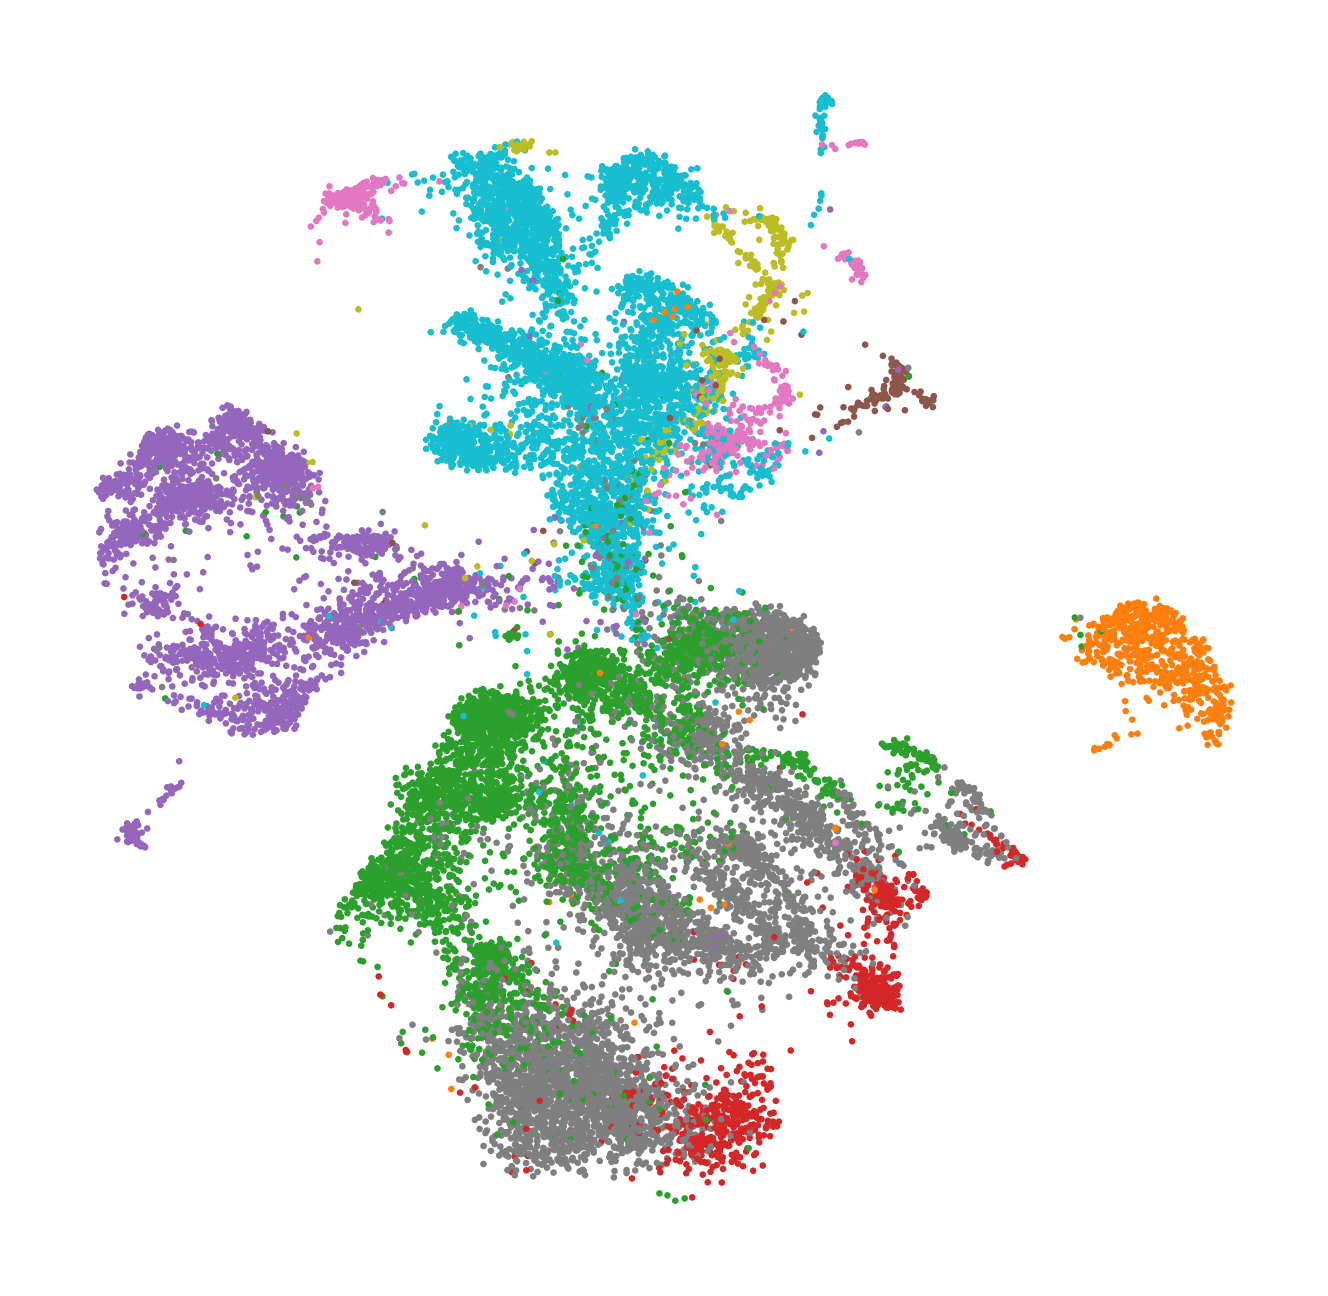

In [24]:
from utils import set_seeds

%matplotlib inline
target_batches = ["Drop-seq", "10x Chromium (v3)"]
plot_data("pbmc_generalization", ['study', 'cell_type'], title="", frameon=False, legend_loc=False, batches_to_exclude=target_batches)

In [ ]:
plot_results("hd-md_generalization", "pbmc_generalization", keys=['study', 'cell_type'], title="", frameon=False, legend_loc=False, batches_to_exclude = [target_batches[0]])

In [ ]:
plot_results("hd-md_generalization", "pbmc_generalization", keys=['study', 'cell_type'], title="", frameon=False, legend_loc=False, batches_to_exclude = target_batches)

In [ ]:
%matplotlib inline
plot_results("desc_generalization", "pbmc_generalization", keys=['study', 'cell_type'], title="", frameon=False, legend_loc=False)

In [ ]:
import SAUCIE
from utils import load_data
import tensorflow as tf
import numpy as np
from anndata import AnnData

dataset = 'pbmc_generalization'
adata = load_data(dataset, normalized=True)

target_batches = ["Drop-seq", "10x Chromium (v3)"]
source_adata = adata[~adata.obs["study"].isin(target_batches)]
target_adata = adata[adata.obs["study"].isin(target_batches)]

for i in range(5):
    tf.reset_default_graph()
    saucie = SAUCIE.SAUCIE(source_adata.shape[1])
    loadtrain = SAUCIE.Loader(source_adata.X, shuffle=True)
    saucie.train(loadtrain, steps=1000)

    loadeval = SAUCIE.Loader(np.concatenate([source_adata.X, target_adata.X]), shuffle=False)
    embedding = saucie.get_embedding(loadeval)

    eval_adata = AnnData.concatenate(source_adata, target_adata)
    saucie_results = AnnData(
        X = embedding,
        obs={
            "cell_type": eval_adata.obs['cell_type'].values,
            "study": eval_adata.obs['study'].values
        }
    )
    saucie_results.write("results/{}/saucie_generalization.h5ad".format(dataset))

import matplotlib.pyplot as plt
saucie_results.obsm['X_umap'] = embedding
sc.pl.umap(saucie_results, color='cell_type')
sc.pl.umap(saucie_results, color='study')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from anndata import AnnData
#from utils import load_results
import numpy as np
import scanpy as sc
import pandas as pd
from tqdm import tqdm
from scipy.stats import sem
import pdb

deep_methods = ['saucie', 'desc', 'scvi', 'hd-md']

methods = ['mnnCorrect', 'seurat', 'harmony', 'conos', 'saucie', 'desc', 'scvi', 'hd-md']
proper_names = ['MNN', 'Seurat', 'Harmony', 'Conos', 'SAUCIE', 'DESC', 'scVI', 'HD-AE']


In [ ]:
for i in range(scores.shape[1]):
    plt.errorbar(resolutions, scores.iloc[:,i], yerr=errors[:,i])

In [ ]:
plot_results(
    "hd-md_generalization", "pbmc_generalization",
    keys=['study', 'cell_type'],
    #batches_to_exclude = ["Drop-seq", "10x Chromium (v3)"],
    frameon=True)

In [11]:
ebms = []
num_neighbors = [15, 25, 50, 100, 200, 300]

for k in num_neighbors:
    ebm = MinMaxScaler().fit_transform(np.load("ebm_scores_{}.npy".format(k))[1:,])
    ebms.append(ebm)
    
ebms = np.array(ebms)
ebms = ebms.mean(axis=2)
ebms = ebms.transpose()

purity_scores = []
num_neighbors = [15, 25, 50, 100, 200, 300]

for k in num_neighbors:
    purity = MinMaxScaler().fit_transform(np.load("purity_scores_{}.npy".format(k))[1:,])
    purity_scores.append(purity)
    
purity_scores = np.array(purity_scores)
purity_scores = purity_scores.mean(axis=2)
purity_scores = purity_scores.transpose()

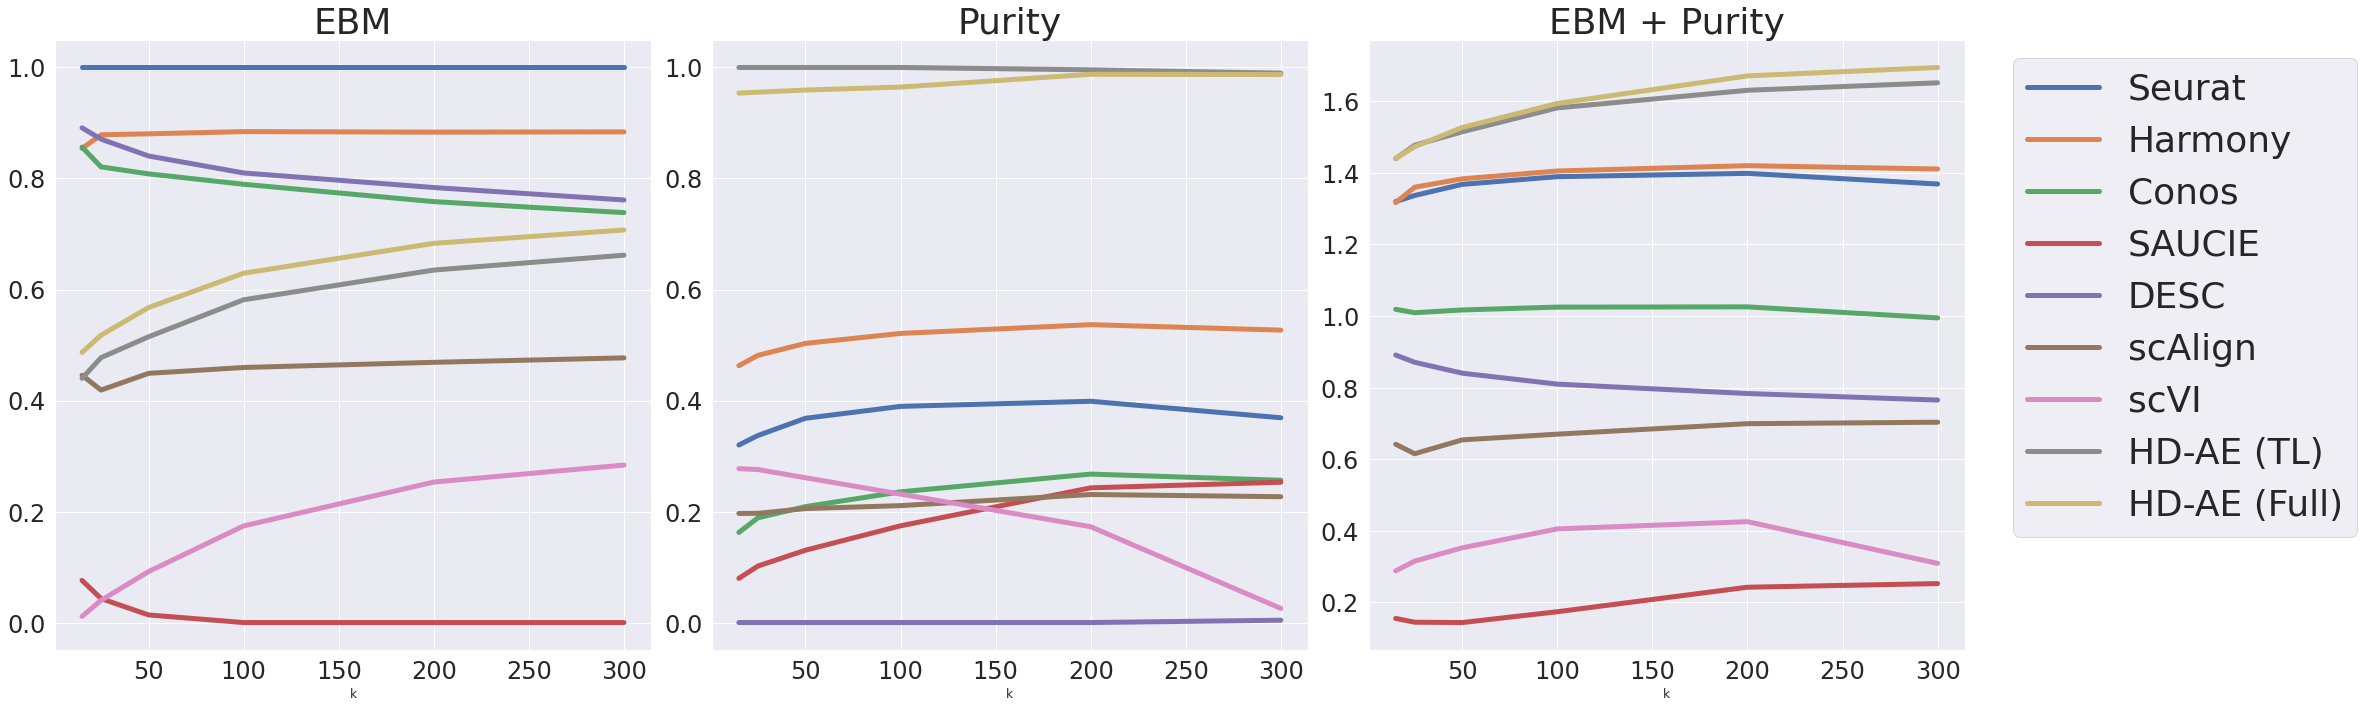

In [12]:
fig = plt.figure(figsize=(33, 10))
ax1 = fig.add_subplot(1, 12, (1, 4))
ax2 = fig.add_subplot(1, 12, (5, 8))
ax3 = fig.add_subplot(1, 12, (9, 12))


for i in range(ebms.shape[0]):
    test = ebms[i,:]
    ax1.plot(num_neighbors, test, label=proper_names[i], lw=5)
ax1.set_xlabel("k")
ax1.set_title("EBM", fontsize=fontsize)

for i in range(ebms.shape[0]):
    test = purity_scores[i,:]
    ax2.plot(num_neighbors, test, label=proper_names[i], lw=5)
    
ax2.set_xlabel("k")
ax2.set_title("Purity", fontsize=fontsize)


for i in range(ebms.shape[0]):
    test = purity_scores[i,:] + ebms[i,:]
    ax3.plot(num_neighbors, test, label=proper_names[i], lw=5)
ax3.set_xlabel("k")
ax3.set_title("EBM + Purity", fontsize=fontsize)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=fontsize)

labelsize=24

ax1.yaxis.set_tick_params(labelsize=labelsize)
ax1.xaxis.set_tick_params(labelsize=labelsize)

ax2.yaxis.set_tick_params(labelsize=labelsize)
ax2.xaxis.set_tick_params(labelsize=labelsize)

ax3.yaxis.set_tick_params(labelsize=labelsize)
ax3.xaxis.set_tick_params(labelsize=labelsize)

plt.tight_layout()